<h1 style="text-align:center">Sentiment Analysis and Sarcasm Detection</h1>

In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import os
import csv
from zipfile import ZipFile

from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import losses
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, SeparableConv1D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dense, Activation, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, SpatialDropout1D

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Part A - Sentiment Analysis:
***

<h4 style="color:indianred"><em>1. <ins>Importing and analysing the data set:</ins></em></h4>

In [ ]:
# Importing the dataset with 10000 most frequent words

from keras.datasets import imdb

# Keras default parameters
start_char = 1
oov_char = 2
index_from = 3

(X_train, y_train),(X_test, y_test) = imdb.load_data(num_words=10000,
                                                                             start_char=start_char, # start of sequence character
                                                                             oov_char=oov_char, # out-of-vocabulary character
                                                                             index_from=index_from) # index from which the vocabulary starts

17464789/17464789 [==============================] - 1s 0us/step


In [ ]:
# Checking the dimensions of the dataset

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [ ]:
X_train[:2]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [ ]:
y_train[:2]

array([1, 0])

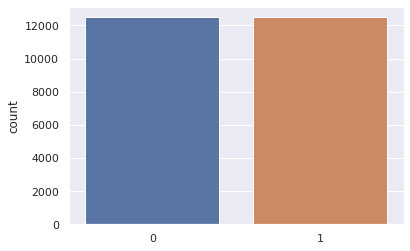

In [ ]:
# Distribution of the target variable in the train dataset

sns.set_theme(style="darkgrid")
sns.set_context('notebook')
sns.countplot(x=y_train)
plt.show()

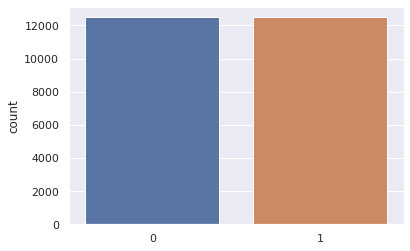

In [ ]:
# Distribution of the target variable in the test dataset

sns.set_theme(style="darkgrid")
sns.set_context('notebook')
sns.countplot(x=y_test)
plt.show()

<em><strong>Observation:</strong></em>
Upon comparing the above 2 distributions, it is evident that the target class is well balanced for both the train and the test datasets.

In [ ]:
# Function to return the median number of words per sample

def get_num_words_per_sample(sample_texts):
    """Return the median number of words per sample.

    Args:
        sample_texts (list): list of texts.

    Returns:
        (int): median number of words per sample.
    """
    num_words = [len(s) for s in sample_texts]
    return np.median(num_words)


In [ ]:
# Number of words per sample for X_train and X_test

print('Number of words per sample:')
print(f'X_train: {get_num_words_per_sample(X_train)}')
print(f'X_test: {get_num_words_per_sample(X_test)}')

Number of words per sample:
X_train: 178.0
X_test: 174.0


In [ ]:
# Function to plot the distribution of the sample lengths

def plot_sample_length_distribution(sample_texts):
    """Plot the distribution of the sample lengths.

    Args:
        sample_texts(list): List of texts.
    """
    sns.set_style('darkgrid')
    sns.set_context('notebook')
    plt.hist([len(s) for s in sample_texts], 50, color='palevioletred')
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

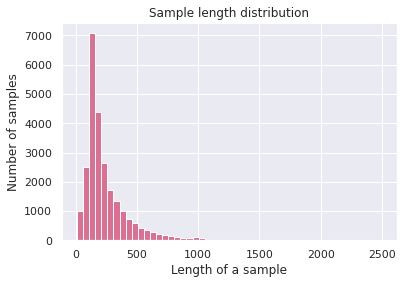

In [ ]:
# Sample Length Distribution of X_train

plot_sample_length_distribution(X_train)

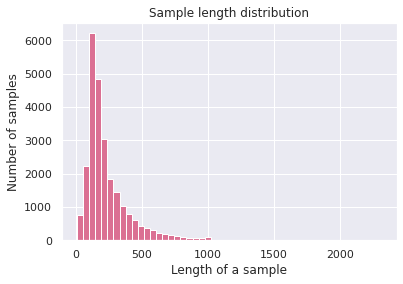

In [ ]:
# Sample Length Distribution of X_test

plot_sample_length_distribution(X_test)

<em><strong>Observation:</strong></em>
From the above analysis and distributions, it is evident that the `number of words per sample` and the `Sample Length Distributions` are very similar for both the train and the test data.

<h4 style="color:indianred"><em>2. <ins>Performing relevant sequence adding to the data:</ins></em></h4>

In [ ]:
# Checking the length of a few samples

print(f"Number of words in the train samples: ({len(X_train[0])}, {len(X_train[1])})")
print(f"Number of words in the test samples: ({len(X_test[0])}, {len(X_test[1])})")

Number of words in the train samples: (218, 189)
Number of words in the test samples: (68, 260)


<em><strong>Observation:</strong></em>
The samples seem to have different sequence lengths. 

In [ ]:
# Defining the parameters

# Using the first 60 words from each review as text length
max_seq_len = 60

# Using a max vocabulary size of 10000 (as mentioned in the Data Description)
max_vocab_size = 10000

# Dimension of the word embeddings
embedding_dim = 100

In [ ]:
# Padding the sequences of train and test data to make all the sequences have the same lengths

X_train_padded = pad_sequences(X_train, maxlen=max_seq_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_seq_len, padding='post', truncating='post')

In [ ]:
# Shape of the padded data

print(X_train_padded.shape)
print(X_test_padded.shape)

(25000, 60)
(25000, 60)


<h4 style="color:indianred"><em>3. <ins>Performing data analysis:</ins></em></h4>

In [ ]:
# Reshaping the train and the test labels

y_train_reshaped = y_train.reshape(-1,1)
y_test_reshaped = y_test.reshape(-1,1)

In [ ]:
# Printing the shape of features and labels

print(f'Shape of features:')
print(f'X train: {X_train_padded.shape}')
print(f'X test: {X_test_padded.shape}\n')
print(f'Shape of labels:')
print(f'y train: {y_train_reshaped.shape}')
print(f'y test: {y_test_reshaped.shape}')

Shape of features:
X train: (25000, 60)
X test: (25000, 60)

Shape of labels:
y train: (25000, 1)
y test: (25000, 1)


<em><strong>Observation:</strong></em>
The IMDB movie reviews dataset has 25000 samples each for Training and Testing.

In [ ]:
# Printing the value of any one feature and it's label

print(f'Value of a feature: {X_train_padded[0]}')
print(f'\nLabel: {y_train_reshaped[0]}')

Value of a feature: [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22]

Label: [1]


<em><strong>Observation:</strong></em>

X_train, X_test: In the IMDB dataset, the reviews have already been preprocessed and each review is encoded as a list of word indices.

y_train, y_test: The sentiments are represented as integer labels [1(Positive) or 0(Negative)]

<h4 style="color:indianred"><em>4. <ins>Decoding the feature value to get original sentence:</ins></em></h4>

In [ ]:
# Retrieving the word index file mapping words to indices

word_index = imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


In [ ]:
# Reversing the word index to obtain a dictionary mapping indices to words

index_word = {idx+index_from: word for (word, idx) in word_index.items()}

In [ ]:
# Function to decode the sentiment labels

def label(y_enc):
    """Returns the sentiment labels

    Args:
        y_enc (int): Encoded sentiment label
    
    Returns:    
        (string): Decoded sentiment label 
    """
    if y_enc == 0:
        return 'negative'
    else:
        return 'positive'

In [ ]:
# Decoding the feature value to get original sentence

# Updating `index_word` to include `start_char` and `oov_char`
index_word[start_char] = "-START-"
index_word[oov_char] = "-OOV-"

# Dataframe to store the decoded feature values for both the Train and Test datasets
X_decoded = pd.DataFrame()

# Decoding the feature values
for i in range(len(X_train)  + len(X_test)):
    if i< 25000:
        X_train_decoded = " ".join(index_word[idx] for idx in X_train[i])
        X_decoded = X_decoded.append(pd.DataFrame([X_train_decoded, label(y_train[i])]).T, ignore_index=True)
    else:
        X_test_decoded = " ".join(index_word[idx] for idx in X_test[i-25000])
        X_decoded = X_decoded.append(pd.DataFrame([X_test_decoded, label(y_test[i-25000])]).T, ignore_index=True)

X_decoded.columns = ['Review', 'Sentiment']

In [ ]:
# Dataframe that has the decoded feature values for both the Train and Test datasets

X_decoded.shape

(50000, 2)

In [ ]:
X_decoded.head()

,Review,Sentiment
0,-START- this film was just brilliant casting l...,positive
1,-START- big hair big boobs bad music and a gia...,negative
2,-START- this has to be one of the worst films ...,negative
3,-START- the -OOV- -OOV- at storytelling the tr...,positive
4,-START- worst mistake of my life br br i picke...,negative


In [ ]:
# Sample Decoded feature

X_decoded.iloc[0,0]

"-START- this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert -OOV- is an amazing actor and now the same being director -OOV- father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for -OOV- and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also -OOV- to the two little boy's that played the -OOV- of norman and paul they were just brilliant children are often left out of the -OOV- list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [ ]:
# Sample Decoded label

X_decoded.iloc[0,1]


'positive'

<h4 style="color:indianred"><em>5. <ins>Designing, training, tuning and testing sequential models:</ins></em></h4>

In [ ]:
# Extracting the vocabulary dictionary containing the 10000 most frequent words in the data set

senti_vocabulary_dict  = {idx: word for idx, word in index_word.items() if idx<10000}

In [ ]:
# Printing the 50 most frequent words in the vocabulary dictionary

{idx: word for idx, word in senti_vocabulary_dict.items() if idx<=50}

{47: 'has',
 19: 'with',
 31: 'one',
 28: 'have',
 45: "it's",
 40: 'like',
 13: 'i',
 37: 'who',
 29: 'he',
 35: 'an',
 17: 'as',
 12: 'it',
 9: 'is',
 11: 'in',
 48: 'if',
 21: 'but',
 23: 'on',
 7: 'of',
 42: 'or',
 41: 'her',
 27: 'his',
 32: 'all',
 14: 'this',
 24: 'not',
 25: 'you',
 6: 'a',
 33: 'at',
 38: 'so',
 50: 'there',
 46: 'out',
 18: 'for',
 30: 'be',
 10: 'br',
 34: 'by',
 36: 'they',
 43: 'just',
 4: 'the',
 39: 'from',
 16: 'was',
 5: 'and',
 8: 'to',
 22: 'film',
 44: 'about',
 20: 'movie',
 15: 'that',
 49: 'some',
 26: 'are',
 1: '-START-',
 2: '-OOV-'}

In [ ]:
# Model 1 - Designing a sequential model with LSTM

model_LSTM = Sequential()

# Embedding layer
model_LSTM.add(Embedding(input_dim=max_vocab_size,
                                           output_dim=embedding_dim,
                                           trainable=True,
                                           embeddings_initializer=None,
                                           input_length=max_seq_len,
                                           name="Embedding"))

# Hidden layers
model_LSTM.add(SpatialDropout1D(rate=0.2))
model_LSTM.add(LSTM(32, return_sequences=False, dropout=0.5, recurrent_dropout=0.5, bias_initializer='random_uniform', name="LSTM")) 
model_LSTM.add(Dense(16, name="Dense"))
model_LSTM.add(Dropout(rate=0.4))

# Output layer
model_LSTM.add(Dense(1, activation='sigmoid', name="Output"))

In [ ]:
# Compiling the LSTM model

adam = optimizers.Adam(lr=0.0001)
model_LSTM.compile(loss='binary_crossentropy', 
                                optimizer=adam, 
                                metrics=['accuracy'])

In [ ]:
# LSTM Model Summary

model_LSTM.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 60, 100)           1000000   
                                                                 
 spatial_dropout1d_18 (Spati  (None, 60, 100)          0         
 alDropout1D)                                                    
                                                                 
 LSTM (LSTM)                 (None, 32)                17024     
                                                                 
 Dense (Dense)               (None, 16)                528       
                                                                 
 dropout_20 (Dropout)        (None, 16)                0         
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                     

In [ ]:
# Function that returns the callbacks to be used in the model

def model_callbacks_LSTM():
    """Returns the callbacks to be used in the model
    
    Returns:    
        (list): List of callbacks 
    """
    monitor_val_acc = EarlyStopping(monitor='val_loss', patience=50)
    model_Checkpoint = ModelCheckpoint('best_model_LSTM.hdf5', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0000001, mode='auto')

    return [model_Checkpoint, monitor_val_acc, reduce_lr]

In [ ]:
# Training the model using the designed Architecture

h_callback_LSTM = model_LSTM.fit(X_train_padded, 
                                                    y_train_reshaped, 
                                                    epochs=10,
                                                    batch_size=512,
                                                    validation_data=(X_test_padded, y_test_reshaped),
                                                    callbacks=model_callbacks_LSTM())

Epoch 1/10
49/49 [==============================] - 17s 287ms/step - loss: 0.6932 - accuracy: 0.5047 - val_loss: 0.6927 - val_accuracy: 0.5319 - lr: 1.0000e-04
Epoch 2/10
49/49 [==============================] - 14s 282ms/step - loss: 0.6924 - accuracy: 0.5129 - val_loss: 0.6922 - val_accuracy: 0.5550 - lr: 1.0000e-04
Epoch 3/10
49/49 [==============================] - 15s 304ms/step - loss: 0.6911 - accuracy: 0.5386 - val_loss: 0.6913 - val_accuracy: 0.5716 - lr: 1.0000e-04
Epoch 4/10
49/49 [==============================] - 14s 283ms/step - loss: 0.6893 - accuracy: 0.5593 - val_loss: 0.6898 - val_accuracy: 0.5861 - lr: 1.0000e-04
Epoch 5/10
49/49 [==============================] - 14s 282ms/step - loss: 0.6859 - accuracy: 0.5931 - val_loss: 0.6861 - val_accuracy: 0.6017 - lr: 1.0000e-04
Epoch 6/10
49/49 [==============================] - 14s 279ms/step - loss: 0.6753 - accuracy: 0.6385 - val_loss: 0.6674 - val_accuracy: 0.6441 - lr: 1.0000e-04
Epoch 7/10
49/49 [======================

In [ ]:
# Evaluating the model accuracy on the test data

loss, accuracy = model_LSTM.evaluate(X_test_padded, y_test_reshaped)
print(f"Loss: {loss}\nAccuracy: {accuracy}")

782/782 [==============================] - 15s 20ms/step - loss: 0.4642 - accuracy: 0.7786
Loss: 0.4642333984375
Accuracy: 0.7785599827766418


In [ ]:
# Function to plot training and validation loss values

def plot_loss(loss, val_loss):
    """Plot the training and the validation loss values.
    
    Args:    
        loss(list): The training loss.
        val_loss(list): The Validation loss.
    """
    
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [ ]:
def plot_accuracy(acc, val_acc):
    """Plot the training and the validation accuracy values.
    
    Args:    
        acc(list): The training loss.
        val_acc(list): The Validation loss.
    """
    plt.figure()
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

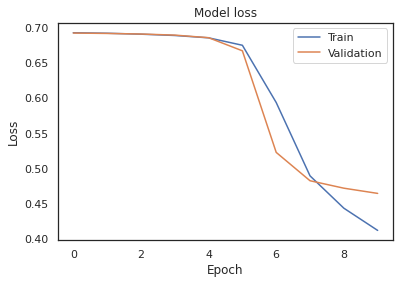

In [ ]:
# Training Loss and Validation Loss

sns.set_theme(style='white')
plot_loss(h_callback_LSTM.history['loss'], h_callback_LSTM.history['val_loss'])

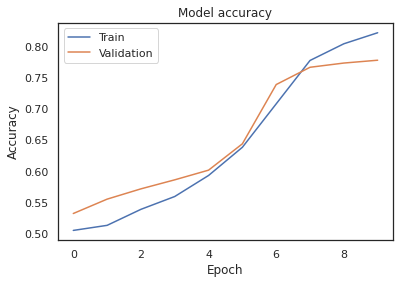

In [ ]:
# Training Accuracy and Validation Accuracy

plot_accuracy(h_callback_LSTM.history['accuracy'], h_callback_LSTM.history['val_accuracy'])

In [ ]:
# Model 2 - Designing a sequential model with CNN

model_CNN = Sequential()

# Embedding layer
model_CNN.add(Embedding(input_dim=max_vocab_size,
                                           output_dim=embedding_dim,
                                           trainable=True,
                                           embeddings_initializer=None,
                                           input_length=max_seq_len,
                                           name="Embedding"))

# Hidden layers
model_CNN.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding='same', bias_initializer='random_uniform'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(SpatialDropout1D(0.2))
model_CNN.add(LSTM(32, return_sequences=False, dropout=0.5, recurrent_dropout=0.5, bias_initializer='random_uniform', name="LSTM"))  
model_CNN.add(Dense(16, name="Dense"))
model_CNN.add(Dropout(0.4)) 

# Output layer
model_CNN.add(Dense(1, activation='sigmoid', name="Output"))

# Compiling the CNN model
adam = optimizers.Adam(lr=0.0001)
model_CNN.compile(loss='binary_crossentropy', 
                              optimizer=adam, 
                              metrics=['accuracy'])

# CNN Model Summary
model_CNN.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 60, 100)           1000000   
                                                                 
 conv1d_19 (Conv1D)          (None, 60, 16)            4816      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 30, 16)           0         
 g1D)                                                            
                                                                 
 spatial_dropout1d_37 (Spati  (None, 30, 16)           0         
 alDropout1D)                                                    
                                                                 
 LSTM (LSTM)                 (None, 32)                6272      
                                                                 
 Dense (Dense)               (None, 16)              

In [ ]:
# Training the model using the CNN Architecture

h_callback_CNN = model_CNN.fit(X_train_padded, 
                                                  y_train_reshaped, 
                                                  epochs=10,
                                                  batch_size=512,
                                                  validation_data=(X_test_padded, y_test_reshaped),
                                                  callbacks=model_callbacks_LSTM())

Epoch 1/10
49/49 [==============================] - 11s 171ms/step - loss: 0.6934 - accuracy: 0.5016 - val_loss: 0.6929 - val_accuracy: 0.5359 - lr: 1.0000e-04
Epoch 2/10
49/49 [==============================] - 8s 156ms/step - loss: 0.6929 - accuracy: 0.5066 - val_loss: 0.6925 - val_accuracy: 0.5790 - lr: 1.0000e-04
Epoch 3/10
49/49 [==============================] - 7s 150ms/step - loss: 0.6921 - accuracy: 0.5246 - val_loss: 0.6918 - val_accuracy: 0.6182 - lr: 1.0000e-04
Epoch 4/10
49/49 [==============================] - 7s 146ms/step - loss: 0.6906 - accuracy: 0.5492 - val_loss: 0.6898 - val_accuracy: 0.6344 - lr: 1.0000e-04
Epoch 5/10
49/49 [==============================] - 8s 160ms/step - loss: 0.6855 - accuracy: 0.6013 - val_loss: 0.6816 - val_accuracy: 0.6587 - lr: 1.0000e-04
Epoch 6/10
49/49 [==============================] - 7s 151ms/step - loss: 0.6576 - accuracy: 0.6520 - val_loss: 0.6123 - val_accuracy: 0.7072 - lr: 1.0000e-04
Epoch 7/10
49/49 [===========================

In [ ]:
# Evaluating the model accuracy on the test data

loss, accuracy = model_CNN.evaluate(X_test_padded, y_test_reshaped)
print(f"Loss: {loss}\nAccuracy: {accuracy}")

782/782 [==============================] - 9s 11ms/step - loss: 0.4556 - accuracy: 0.7833
Loss: 0.4555854797363281
Accuracy: 0.7832800149917603


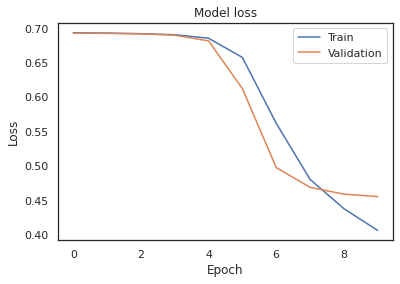

In [ ]:
# Training Loss and Validation Loss

sns.set_theme(style='white')
plot_loss(h_callback_CNN.history['loss'], h_callback_CNN.history['val_loss'])

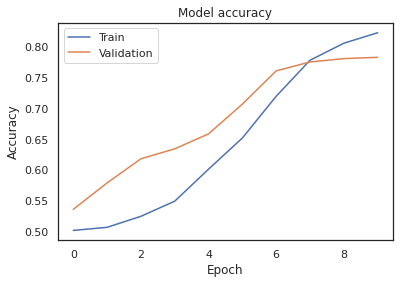

In [ ]:
# Training Accuracy and Validation Accuracy

plot_accuracy(h_callback_CNN.history['accuracy'], h_callback_CNN.history['val_accuracy'])

<em><strong>Observation:</strong></em>
The convolution layer does feature selection on the embedding vector and achieves state-of-the-art results in many NLP problems. An improvement in the accuracy is evident over the LSTM model.

In [ ]:
# Tuning the sequential model

# Function that creates a model for KerasClassifier wrapper

def create_model(learning_rate=0.0001, lstm_neurons=64):
    """Create a model for KerasClassifier wrapper
    
    Args:    
        learning_rate (float): The learning rate of the model.
        lstm_neurons (int): The number of neurons in the LSTM layer

    Returns:    
        model_CNN(model): The compiled model
    """
    
    # Creating a sentiment classification model 
    model_CNN = Sequential()

    # Embedding layer
    model_CNN.add(Embedding(input_dim=max_vocab_size,
                                              output_dim=embedding_dim,
                                              trainable=True,
                                              embeddings_initializer=None,
                                              input_length=max_seq_len,
                                              name="Embedding"))

    # Hidden layers
    model_CNN.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding='same', bias_initializer='random_uniform'))
    model_CNN.add(MaxPooling1D(pool_size=2))
    model_CNN.add(SpatialDropout1D(rate=0.2))
    model_CNN.add(LSTM(lstm_neurons, return_sequences=False, dropout=0.5, recurrent_dropout=0.5, bias_initializer='random_uniform', name="LSTM")) 
    model_CNN.add(Dense(16, name="Dense"))
    model_CNN.add(Dropout(rate=0.4))

    # Output layer
    model_CNN.add(Dense(1, activation='sigmoid', name="Output"))

    # Compiling the model
    adam = optimizers.Adam(learning_rate=learning_rate)
    model_CNN.compile(loss='binary_crossentropy', 
                                  optimizer=adam, 
                                  metrics=['accuracy'])
    return model_CNN

In [ ]:
# Hyperparameter tuning using Grid Search Cross Validation

# Creating a KerasClassifier
model_cv = KerasClassifier(build_fn=create_model)

# Grid Search parameters 
param_grid = {'learning_rate': [1e-4, 1e-5 ],
                      'lstm_neurons': [32, 64]
                     }

# Performing grid search cross validation
grid_cv = GridSearchCV(estimator=model_cv, 
                                    param_grid=param_grid,
                                    scoring='accuracy',
                                    n_jobs=-1,
                                    cv=3)

grid_cv.fit(X_train_padded, y_train_reshaped, verbose=0)

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f9acbd5d310>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 1e-05],
                         'lstm_neurons': [32, 64]},
             scoring='accuracy')

In [ ]:
# Printing the best parameters for the given model according to Grid search CV

print(f'Best params: {grid_cv.best_params_}')
print(f'Train accuracy using the best hyperparameters: {round(grid_cv.score(X_train_padded, y_train_reshaped), 2)}')
print(f'Test accuracy using the best hyperparameters: {round(grid_cv.score(X_test_padded, y_test_reshaped), 2)}')

Best params: {'learning_rate': 0.0001, 'lstm_neurons': 64}
782/782 [==============================] - 8s 9ms/step
Train accuracy using the best hyperparameters: 0.7
782/782 [==============================] - 7s 9ms/step
Test accuracy using the best hyperparameters: 0.67


In [ ]:
# Function to create the sentiment classification model with the best parameters from Grid Search cross validation

def best_model():
    """Create the model with the best parameters
    
    Returns:    
        model_CNN(model): The compiled model with the best parameters
    """
    model_CNN = Sequential()

    # Embedding layer
    model_CNN.add(Embedding(input_dim=max_vocab_size,
                                              output_dim=embedding_dim,
                                              trainable=True,
                                              embeddings_initializer=None,
                                              input_length=max_seq_len,
                                              name="Embedding"))

    # Hidden layers
    model_CNN.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding='same', bias_initializer='random_uniform'))
    model_CNN.add(MaxPooling1D(pool_size=2))
    model_CNN.add(SpatialDropout1D(0.2))
    model_CNN.add(LSTM(64, return_sequences=False, dropout=0.5, recurrent_dropout=0.5, bias_initializer='random_uniform', name="LSTM"))  
    model_CNN.add(Dense(16, name="Dense"))
    model_CNN.add(Dropout(0.4)) 

    # Output layer
    model_CNN.add(Dense(1, activation='sigmoid', name="Output"))

    # Compiling the model
    adam = optimizers.Adam(learning_rate=1e-4)
    model_CNN.compile(loss='binary_crossentropy', 
                                  optimizer=adam, 
                                  metrics=['accuracy'])
    model_CNN.summary()

    return model_CNN

In [ ]:
# Training the sentiment classifier with the best parameters from Grid Search cross validation

model_best = best_model()
h_callback_best = model_best.fit(X_train_padded, 
                                                 y_train_reshaped, 
                                                 epochs=10,
                                                 batch_size=512,
                                                 validation_data=(X_test_padded, y_test_reshaped),
                                                 callbacks=model_callbacks_LSTM())

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 60, 100)           1000000   
                                                                 
 conv1d_27 (Conv1D)          (None, 60, 16)            4816      
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 30, 16)           0         
 g1D)                                                            
                                                                 
 spatial_dropout1d_45 (Spati  (None, 30, 16)           0         
 alDropout1D)                                                    
                                                                 
 LSTM (LSTM)                 (None, 64)                20736     
                                                                 
 Dense (Dense)               (None, 16)              

In [ ]:
# Evaluating the model accuracy on the test data

loss, accuracy = model_best.evaluate(X_test_padded, y_test_reshaped)
print(f"Loss: {loss}\nAccuracy: {accuracy}")

782/782 [==============================] - 8s 11ms/step - loss: 0.4617 - accuracy: 0.7785
Loss: 0.4617423415184021
Accuracy: 0.7785199880599976


<h4 style="color:indianred"><em>6. <ins>Using the designed model to print the prediction on any sample:</ins></em></h4>

In [ ]:
# Sample data

X_sample = X_test_padded[1].reshape(1, max_seq_len)

In [ ]:
# Shape of the sample data

X_sample.shape

(1, 60)

In [ ]:
# Getting the prediction for the sample data using the designed model

pred = model_best.predict(X_sample)
pred

1/1 [==============================] - 0s 28ms/step


array([[0.89340836]], dtype=float32)

In [ ]:
# Transforming the prediction into labels

pred_sentiment = "positive" if pred>0.5 else "negative" 
pred_sentiment

'positive'

In [ ]:
# Printing the prediction on the sample

print(f'Predicted label: {pred_sentiment}')
print(f'Actual label: {label(y_test[1])}')

Predicted label: positive
Actual label: positive


### Part B - Sarcasm Detection:
***

<h4 style="color:indianred"><em>1. <ins>Reading and exploring the data:</ins></em></h4>

In [ ]:
# Reading the dataset

sarcasm_headlines = pd.read_json("/content/drive/MyDrive/AIML/NLP/Project2 - Seq NLP/Sarcasm_Headlines_Dataset.json", lines=True)
sarcasm_headlines.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
sarcasm_headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [ ]:
sarcasm_headlines.describe(include='all')

,is_sarcastic,headline,article_link
count,28619.000000,28619,28619
unique,NaN,28503,28617
top,NaN,"'no way to prevent this,' says only nation whe...",https://politics.theonion.com/nation-not-sure-...
freq,NaN,12,2
mean,0.476397,NaN,NaN
std,0.499451,NaN,NaN
min,0.000000,NaN,NaN
25%,0.000000,NaN,NaN
50%,0.000000,NaN,NaN
75%,1.000000,NaN,NaN


In [ ]:
# Checking for missing values in the dataset

sarcasm_headlines.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

<em><strong>Observation:</strong></em>There are no null values in the dataset

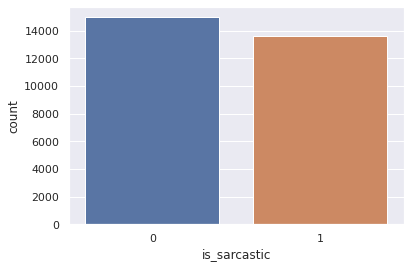

0    0.523603
1    0.476397
Name: is_sarcastic, dtype: float64

In [ ]:
# Distribution of the target variable.

sns.set_theme(style='darkgrid')
sns.set_context('notebook')
sns.countplot(data=sarcasm_headlines, x='is_sarcastic')
plt.show()
sarcasm_headlines.is_sarcastic.value_counts(normalize=True)

<em><strong>Insight:</strong></em>
From the above countplot, it is evident that the target class is almost balanced.

<h4 style="color:indianred"><em>2. <ins>Retaining the relevant columns:</ins></em></h4>

In [ ]:
# Dropping the 'article_link' column as it is not required for the model and retaining the other columns

sarcasm_headlines.drop(['article_link'], axis=1, inplace=True)


In [ ]:
sarcasm_headlines.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [ ]:
# Checking for duplicate values

sarcasm_headlines.duplicated().sum()

116

In [ ]:
# Removing the duplicates

sarcasm_headlines.drop_duplicates(inplace=True)

In [ ]:
sarcasm_headlines.duplicated().sum()

0

<h4 style="color:indianred"><em>3. <ins>Getting the length of each sentence:</ins></em></h4>

In [ ]:
# Create column 'text_len' to store the length of each sentence

sarcasm_headlines['text_len'] = [len(txt) for txt in sarcasm_headlines.headline]

In [ ]:
sarcasm_headlines.head()

,is_sarcastic,headline,text_len
0,1,thirtysomething scientists unveil doomsday clo...,61
1,0,dem rep. totally nails why congress is falling...,79
2,0,eat your veggies: 9 deliciously different recipes,49
3,1,inclement weather prevents liar from getting t...,52
4,1,mother comes pretty close to using word 'strea...,61


In [ ]:
sarcasm_headlines.text_len.describe()

count    28503.000000
mean        62.380241
std         20.706474
min          7.000000
25%         49.000000
50%         62.000000
75%         75.000000
max        926.000000
Name: text_len, dtype: float64

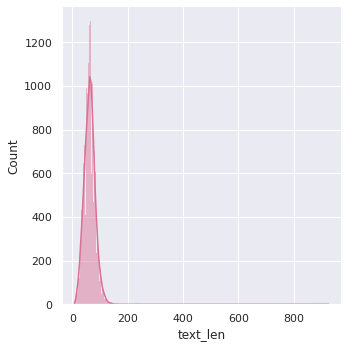

In [ ]:
sns.set_style('darkgrid')
sns.set_context('notebook')
sns.displot(sarcasm_headlines.text_len, kde=True, color='palevioletred')
plt.show()

<em><strong>Insight:</strong></em>
The average length of the sentences seems to be around 62 words.

In [ ]:
sarcasm_headlines.text_len.value_counts()

65     700
62     671
64     622
63     610
69     601
      ... 
159      1
144      1
190      1
151      1
7        1
Name: text_len, Length: 154, dtype: int64

<h4 style="color:indianred"><em>4. <ins>Defining the parameters:</ins></em></h4>

In [ ]:
# Maximum length of each sentence
max_text_len = 60

# Vocabulary size
max_features = 10000

# Dimension of the word vector
embedding_dim = 300

<h4 style="color:indianred"><em>5. <ins>Getting the indices for words:</ins></em></h4>

In [ ]:
# Building the dictionary of indices

headlines_text = sarcasm_headlines.headline

twitter_tokenizer = Tokenizer(num_words=max_features)
twitter_tokenizer.fit_on_texts(headlines_text)

In [ ]:
# Changing  texts into sequence of indexes

headline_idx = twitter_tokenizer.texts_to_sequences(headlines_text)

In [ ]:
headline_idx[:5]

[[354, 3158, 7456, 2635, 2, 658, 1114],
 [7457, 1766, 773, 3159, 46, 237, 10, 1835, 1042, 7, 1523, 2148, 1836],
 [861, 32, 259, 644, 1478],
 [1585, 6407, 5649, 15, 141, 1, 151],
 [471, 490, 319, 920, 1, 583, 548, 6408]]

In [ ]:
# Padding the sequences to make all the sequences have the same lengths

headline_idx = pad_sequences(headline_idx, max_text_len, padding='post', truncating='post')

In [ ]:
headline_idx[:2]

array([[ 354, 3158, 7456, 2635,    2,  658, 1114,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [7457, 1766,  773, 3159,   46,  237,   10, 1835, 1042,    7, 1523,
        2148, 1836,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]], dtype=int32)

<h4 style="color:indianred"><em>6. <ins>Creating the features and labels:</ins></em></h4>

In [ ]:
# Splitting the data into features X and labels y

X = headline_idx
y = sarcasm_headlines.is_sarcastic.values.reshape(-1, 1)

In [ ]:
X[:2]

array([[ 354, 3158, 7456, 2635,    2,  658, 1114,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [7457, 1766,  773, 3159,   46,  237,   10, 1835, 1042,    7, 1523,
        2148, 1836,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]], dtype=int32)

In [ ]:
y

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [ ]:
print(f'Number of Samples: {len(X)}')
print(f'Number of Labels: {len(y)}' )

Number of Samples: 28503
Number of Labels: 28503


In [ ]:
# Splitting the data into train & test with 70:30 proportion

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

In [ ]:
# Shape of the train and test variables

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20033, 60)
(8586, 60)
(20033, 1)
(8586, 1)


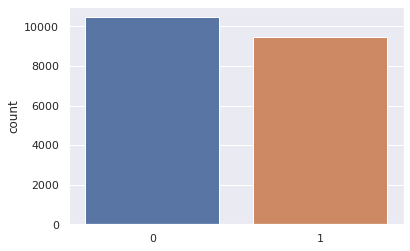

In [ ]:
# Distribution of the target variable in the train dataset

sns.set_theme(style="darkgrid")
sns.set_context('notebook')
sns.countplot(x=y_train)
plt.show()

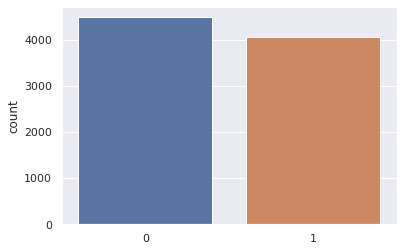

In [ ]:
# Distribution of the target variable in the test dataset

sns.set_theme(style="darkgrid")
sns.set_context('notebook')
sns.countplot(x=y_test)
plt.show()

<em><strong>Observation:</strong></em>
Upon comparing the above 2 distributions, it is evident that the target class distribution is the same for both the train and the test datasets.

<h4 style="color:indianred"><em>7. <ins>Getting the vocabulary size:</ins></em></h4>

In [ ]:
# Getting the original vocabulary size

vocab_size = len(twitter_tokenizer.word_index)
print(f'vocabulary size: {vocab_size}')

vocabulary size: 30884


In [ ]:
# Extracting the vocabulary dictionary containing the 10000 most frequent words in the data set

twitter_vocabulary_dict  = {idx: word for idx, word in twitter_tokenizer.index_word.items() if idx<max_features}

In [ ]:
# Printing the 50 most frequent words in the vocabulary dictionary

{idx: word for idx, word in twitter_vocabulary_dict.items() if idx<=50}

{1: 'to',
 2: 'of',
 3: 'the',
 4: 'in',
 5: 'for',
 6: 'a',
 7: 'on',
 8: 'and',
 9: 'with',
 10: 'is',
 11: 'new',
 12: 'trump',
 13: 'man',
 14: 'at',
 15: 'from',
 16: 'about',
 17: 'by',
 18: 'after',
 19: 'you',
 20: 'out',
 21: 'up',
 22: 'be',
 23: 'this',
 24: 'as',
 25: 'that',
 26: 'it',
 27: 'how',
 28: 'not',
 29: 'he',
 30: 'his',
 31: 'are',
 32: 'your',
 33: 'just',
 34: 'what',
 35: 'all',
 36: 'who',
 37: 'has',
 38: 'will',
 39: 'report',
 40: 'into',
 41: 'more',
 42: 'one',
 43: 'have',
 44: 'year',
 45: 'over',
 46: 'why',
 47: 'u',
 48: 'day',
 49: 'area',
 50: 'woman'}

<h4 style="color:indianred"><em>8. <ins>Creating a weight matrix using GloVe embeddings:</ins></em></h4>

In [ ]:
# Extracting ‘glove.6B.zip’ into a new folder (unzipped)

file_name = '/content/drive/MyDrive/AIML/NLP/Project2 - Seq NLP/glove.6B.zip'
with ZipFile(file_name, 'r') as zip_file:
    zip_file.extractall()

In [ ]:
os.listdir()

['.config',
 'glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt',
 'drive',
 'sample_data']

In [ ]:
# Path of the GloVe embeddings

path = '/content/glove.6B.300d.txt' 

In [ ]:
# Function to get the GloVE embeddings

def get_glove_vectors(path):
    """Return the dictionary of pre-trained global vectors
    
    Args:    
        path (str): The path of the GloVe embeddings textfile.

    Returns:    
        glove_vector_dict (dict): The dictionary containing words with their global vectors
    """
    # Dictionary to store the GloVe word embeddings 
    glove_vector_dict = {}

    with open(path) as f:
        for line in f:            
            values = line.split()            
            word = values[0]            
            vector = values[1:]            
            glove_vector_dict[word] = np.asarray(vector, dtype='float32')
            
    return glove_vector_dict


In [ ]:
# Extracting the dictionary of GloVe vectors

glove_vectors_dict = get_glove_vectors(path)

In [ ]:
# Displaying a few glove vectors

glove_vectors_df = pd.DataFrame(glove_vectors_dict).T
glove_vectors_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
chanty,0.392700,-0.022505,0.30458,0.187990,0.14118,0.724030,-0.25781,-0.137290,-0.016521,0.595960,...,-0.182950,0.406630,-0.343630,-0.270400,-0.593680,0.016447,0.140740,0.463940,-0.36957,-0.287180
kronik,0.136790,-0.139090,-0.36089,0.079864,0.32149,0.263870,-0.10990,0.044420,0.083869,0.791330,...,0.036419,-0.036845,-0.348150,0.064732,-0.000577,-0.133790,0.428960,-0.023320,0.41021,-0.393080
rolonda,0.075713,-0.040502,0.18345,0.512300,-0.22856,0.839110,0.17878,-0.713010,0.326900,0.695350,...,-0.388530,0.545850,-0.035050,-0.184360,-0.197000,-0.350030,0.160650,0.218380,0.30967,0.437610
zsombor,0.814510,-0.362210,0.31186,0.813810,0.18852,-0.313600,0.82784,0.296560,-0.085519,0.475970,...,0.130880,0.106120,-0.408110,0.313380,-0.430250,0.069798,-0.207690,0.075486,0.28408,-0.175590
sandberger,0.429191,-0.296897,0.15011,0.245201,-0.00352,-0.057697,0.14090,-0.222294,0.221153,0.767218,...,0.128146,0.097552,-0.130981,-0.142839,-0.175458,-0.168996,-0.022512,0.289750,0.32618,-0.059053


In [ ]:
# Function to extract glove vectors for the given vocabulary

def filter_glove_words_twitter(vocabulary_dict, glove_vectors_dict, embedding_dim=300):
    """Extract the glove vectors for the given vocabulary
    
    Args:    
        vocabulary_dict (dict): The vocabulary set.
        glove_vectors_dict (dict): The glove words with their embeddings
        embedding_dim (int): The dimension of the embeddings

    Returns:    
        embedding_matrix (numpy array): The matrix containing the embeddings for the vocabulary
    """
    # Creating a matrix to store the vectors    
    embedding_matrix = np.zeros((len(vocabulary_dict)+1, embedding_dim))

    for i, word in vocabulary_dict.items():    
        embedding_vector = glove_vectors_dict.get(word)
        
        if embedding_vector is not None:
            # Words not found in the glove_vectors_dict will be all-zeros.        
            embedding_matrix[i] = embedding_vector
        
    return embedding_matrix

In [ ]:
# Extracting the Weight matrix using GloVe embeddings for the given vocabulary

twitter_embedding_matrix = filter_glove_words_twitter(twitter_vocabulary_dict, glove_vectors_dict, embedding_dim)

In [ ]:
len(twitter_embedding_matrix)

10000

<h4 style="color:indianred"><em>9. <ins>Defining and compiling a Bidirectional LSTM model:</ins></em></h4>

In [ ]:
# Defining a Bidirectional LSTM model

model_BiLSTM = Sequential()

# Embedding layer
model_BiLSTM.add(Embedding(input_dim=max_features,
                                              output_dim=embedding_dim,
                                              trainable=False,
                                              embeddings_initializer=Constant(twitter_embedding_matrix),
                                              input_length=max_text_len,
                                              name="Embedding"))

# Hidden layers
model_BiLSTM.add(Dense(embedding_dim, activation='relu', name="Dense1"))
model_BiLSTM.add(Bidirectional(LSTM(128, return_sequences=True, name="Bi_LSTM"))) 
model_BiLSTM.add(Dense(64, name="Dense2"))
model_BiLSTM.add(SpatialDropout1D(rate=0.25))
model_BiLSTM.add(Dense(32, name="Dense3"))

# Output layer
model_BiLSTM.add(Dense(1, activation='sigmoid', name="Output"))

In [ ]:
# Compiling the Bidirectional LSTM model

adam = optimizers.Adam(lr=0.00001)
model_BiLSTM.compile(loss='binary_crossentropy', 
                                  optimizer=adam, 
                                  metrics=['accuracy'])

In [ ]:
# Model Summary

model_BiLSTM.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 60, 300)           3000000   
                                                                 
 Dense1 (Dense)              (None, 60, 300)           90300     
                                                                 
 bidirectional_13 (Bidirecti  (None, 60, 256)          439296    
 onal)                                                           
                                                                 
 Dense2 (Dense)              (None, 60, 64)            16448     
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 60, 64)           0         
 lDropout1D)                                                     
                                                                 
 Dense3 (Dense)              (None, 60, 32)          

<h4 style="color:indianred"><em>10. <ins>Fitting the model and checking the validation accuracy:</ins></em></h4>

In [ ]:
# Function that returns the callbacks to be used in the model

def model_callbacks():
    """Returns the callbacks to be used in the model
    
    Returns:    
        (list): List of callbacks 
    """
    monitor_val_acc = EarlyStopping(monitor='val_loss', patience=50)
    model_Checkpoint = ModelCheckpoint('best_model.hdf5', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0000001, mode='auto')

    return [model_Checkpoint, monitor_val_acc, reduce_lr]

In [ ]:
# Training the model using the Bidirectional LSTM Architecture

h_callback_BiLSTM = model_BiLSTM.fit(X_train, 
                                                          y_train, 
                                                          epochs=30,
                                                          batch_size=64,
                                                          validation_data=(X_test, y_test),
                                                          callbacks=model_callbacks())

Epoch 1/30
312/312 [==============================] - 12s 28ms/step - loss: 0.6920 - accuracy: 0.5256 - val_loss: 0.6899 - val_accuracy: 0.5388
Epoch 2/30
312/312 [==============================] - 8s 26ms/step - loss: 0.6872 - accuracy: 0.5479 - val_loss: 0.6831 - val_accuracy: 0.5618
Epoch 3/30
312/312 [==============================] - 8s 25ms/step - loss: 0.6613 - accuracy: 0.6092 - val_loss: 0.5714 - val_accuracy: 0.7130
Epoch 4/30
312/312 [==============================] - 8s 25ms/step - loss: 0.5184 - accuracy: 0.7489 - val_loss: 0.4947 - val_accuracy: 0.7652
Epoch 5/30
312/312 [==============================] - 8s 25ms/step - loss: 0.4808 - accuracy: 0.7738 - val_loss: 0.4708 - val_accuracy: 0.7792
Epoch 6/30
312/312 [==============================] - 8s 25ms/step - loss: 0.4620 - accuracy: 0.7854 - val_loss: 0.4581 - val_accuracy: 0.7885
Epoch 7/30
312/312 [==============================] - 8s 25ms/step - loss: 0.4484 - accuracy: 0.7929 - val_loss: 0.4452 - val_accuracy: 0.796

In [ ]:
# Checking the validation accuracy of the model

accuracy = model_BiLSTM.evaluate(X_test, y_test)[1]
print(f'Validation accuracy: {accuracy}')

268/268 [==============================] - 2s 8ms/step - loss: 0.3528 - accuracy: 0.8450
Validation accuracy: 0.8450044989585876


<em><strong>Observation:</strong></em>
The model has a validation accuracy of 84.5%

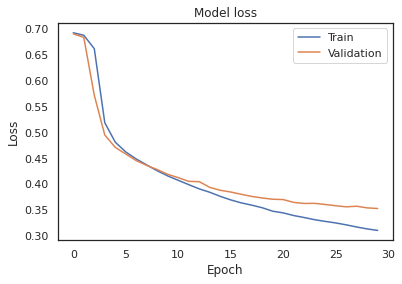

In [ ]:
# Training Loss and Validation Loss

sns.set_theme(style='white')
plot_loss(h_callback_BiLSTM.history['loss'], h_callback_BiLSTM.history['val_loss'])

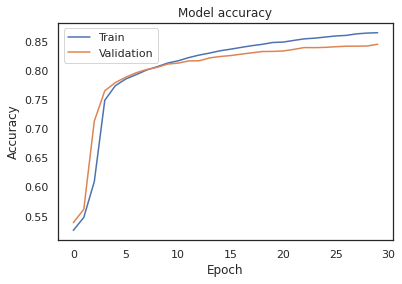

In [ ]:
# Training Accuracy and Validation Accuracy

plot_accuracy(h_callback_BiLSTM.history['accuracy'], h_callback_BiLSTM.history['val_accuracy'])